# Multi-modal document classification using Tensorflow

This notebook illustrates how to use `tf.keras` and `tf.data` for training a model to classifiy document images from the Tobacco-3482 dataset.

The model consists of an image path, using a VGG16 convolutional neural network pretrained on ImageNet, and a text path using a Tfidf-Vectorizer. Both paths are fused to produce a classification of the input document image.

The input pipeline uses `tf.data.Dataset` to optimize the loading, preprocessing and batching of the training and validation examples during training.

In [ ]:
import datetime
import os
import pathlib
import random

from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
BATCH_SIZE = 16
IMG_SIZE = [224, 224]
CHANNELS = 3
VOCAB_SIZE = 50000
NUM_LABELS = 10
TRAIN_SIZE = 1500
VAL_SIZE = 500

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# Initialize global constants for the preprocess_input function 
# (see https://github.com/tensorflow/tensorflow/issues/29931)
temp = tf.zeros([BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], CHANNELS])
_ = tf.keras.applications.vgg16.preprocess_input(temp)

In [ ]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
def load_and_resize_image(img_path):
  img_raw = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img_raw, channels=CHANNELS)
  img = tf.image.resize(img, IMG_SIZE)
  return img

In [ ]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
def get_file_paths_and_labels(data_root):
  """
  Returns a list of paths to image and text files, corresonding 
  class labels and mapping of class names to label index.
  """
  image_paths = sorted([str(path) for path in data_root.glob('*/*.jpg')])
  random.shuffle(image_paths)

  text_paths = [os.path.splitext(path)[0] + '.txt' for path in image_paths]

  label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
  label_to_index = dict((name, index) for index, name in enumerate(label_names))
  labels = [label_to_index[pathlib.Path(path).parent.name] for path in image_paths]

  return image_paths, text_paths, labels, label_to_index


## Dataset

The original Tobacco-3482 dataset can be downloaded here: ADD_LINK

In the version that's used here, the original TIF images have been converted to JPEG, and the text of each image has been extracted using `pytesseract` and is stored alongside the image files.

In [ ]:
#!unzip '/gdrive/My Drive/Tobacco3482.zip' -d '/gdrive/My Drive/Tobacco3482/'

In [ ]:
data_root = pathlib.Path('/gdrive/My Drive/Tobacco3482/Tobacco3482/')

for item in data_root.iterdir():
  print(item)

/gdrive/My Drive/Tobacco3482/Tobacco3482/README.txt
/gdrive/My Drive/Tobacco3482/Tobacco3482/ADVE
/gdrive/My Drive/Tobacco3482/Tobacco3482/Email
/gdrive/My Drive/Tobacco3482/Tobacco3482/Form
/gdrive/My Drive/Tobacco3482/Tobacco3482/Letter
/gdrive/My Drive/Tobacco3482/Tobacco3482/Memo
/gdrive/My Drive/Tobacco3482/Tobacco3482/Scientific
/gdrive/My Drive/Tobacco3482/Tobacco3482/Resume
/gdrive/My Drive/Tobacco3482/Tobacco3482/Report
/gdrive/My Drive/Tobacco3482/Tobacco3482/Note
/gdrive/My Drive/Tobacco3482/Tobacco3482/News


Some examples from the different classes are shown below:

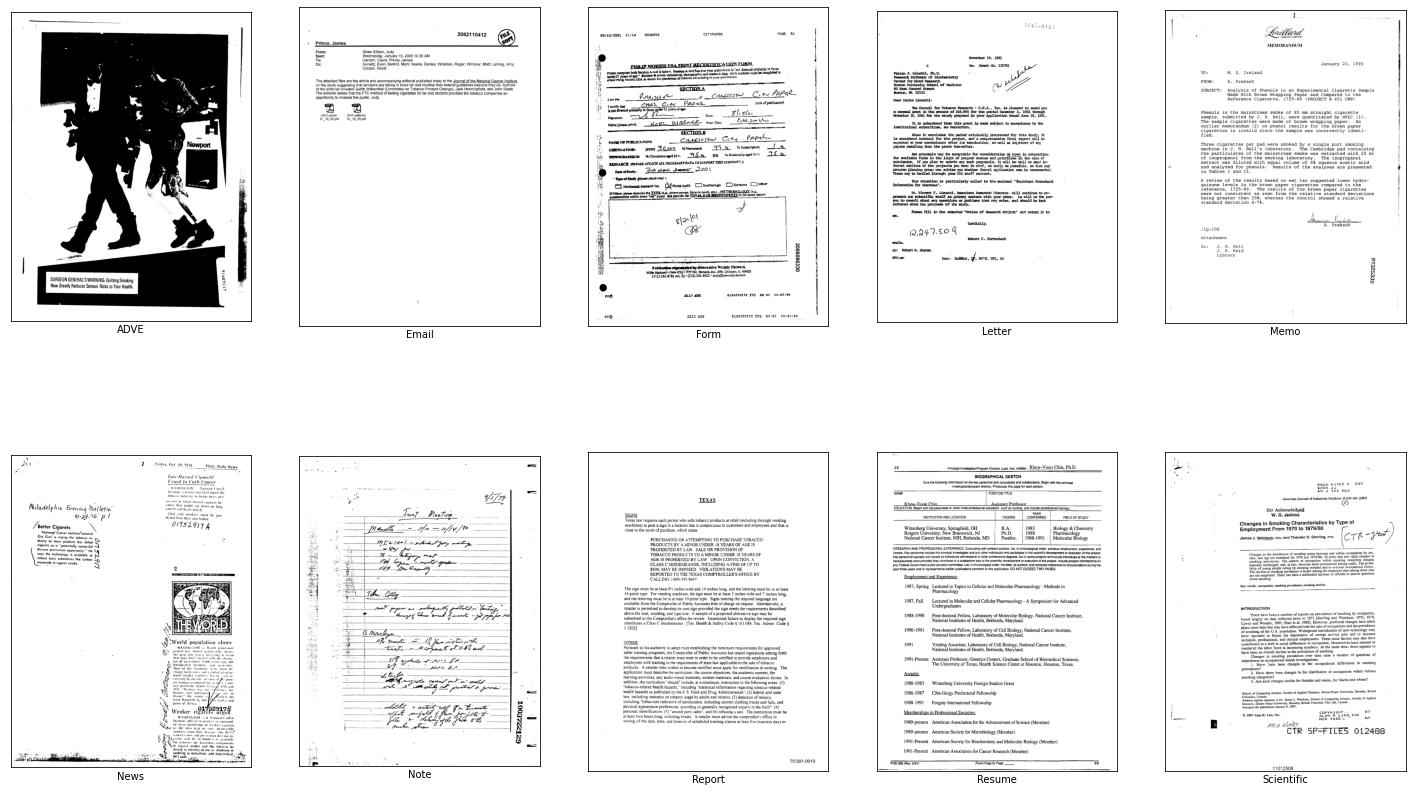

In [ ]:
image_paths, text_paths, labels, label_to_index = get_file_paths_and_labels(data_root)

plt.figure(figsize=(25, 15))
for i, (label_name, label_int) in enumerate(label_to_index.items()):
  sample_idx = labels.index(label_int)
  image_path = image_paths[sample_idx]
  img = Image.open(image_path).convert('1')
  plt.subplot(2, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img)
  plt.xlabel(label_name)
plt.show()

We'll use the recently introduced `TextVectorization` layer from Keras to turn text into tf-idf count vectors. The advantage over e.g. sklearn's `TfidfVectorizer` is that it can be used as a layer in the network architecture, rather than having to pre-process all texts. However, it needs to be fit to the dataset in order to infer the vocabulary first.

In [ ]:
def fit_vocabulary(text_paths, vocab_size=VOCAB_SIZE):
  texts = []
  for text_path in text_paths:
    with open(text_path, 'r') as f:
      texts.append(f.read())

  vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='tf-idf')
  vectorizer.adapt(texts)
  return vectorizer


For multi-modal input data, like images and text, a `tf.data.Dataset` can be created that contains the input examples as the first component, and the labels as the second, by using `tf.data.Dataset.zip` consecutively.

In [ ]:
def zip_datasets(a, b, c):
  """
  Returns a zipped tf.data.Dataset from the three input datasets, 
  where the first two define the multi-modal input data (e.g. images
  and texts) and the third the class labels.
  """
  return tf.data.Dataset.zip((tf.data.Dataset.zip((a, b)), c))


def create_input_pipeline(image_paths, text_paths, labels, 
                          batch_size=BATCH_SIZE, is_training=False):
  """
  Create a tf.data.Dataset pipeline from the given file paths and labels.
  The pipeline includes image preprocessing, batching and creates a zipped
  dataset that feeds both images and text to the input layer. 
  If `is_train==True` the dataset also gets shuffle and repeated for being 
  used as training input.
  """
  image_ds = tf.data.Dataset.from_tensor_slices(image_paths)
  image_ds = image_ds.map(load_and_resize_image).map(preprocess_input)
  
  texts = []
  for text_path in text_paths:
    with open(text_path, 'r') as f:
      texts.append(f.read())

  text_ds = tf.data.Dataset.from_tensor_slices(texts)
  label_ds = tf.data.Dataset.from_tensor_slices(labels)

  ds = zip_datasets(image_ds, text_ds, label_ds)

  if is_training:
    ds = ds.shuffle(buffer_size=len(image_paths)).repeat()

  ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
  return ds



In [ ]:
def build_vgg16_tfidf_model(vectorizer):
  """
  Builds a keras.Model consisting of a pretrained VGG16 network fused
  with a tfidf layer.
  """

  # Image path: using a VGG16 network, pretrained on ImageNet
  vgg16_model = tf.keras.applications.VGG16(
      input_shape=[IMG_SIZE[0], IMG_SIZE[1], CHANNELS],
      include_top=False, weights='imagenet')
  vgg16_model.trainable = True

  image_input = tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], CHANNELS))
  image_model = vgg16_model(image_input)
  # The output of the image path are the averaged values of each convolutional 
  # filter in the top layer
  image_model = tf.keras.layers.GlobalAveragePooling2D()(image_model)

  # Text path: use the tf-idf vectorizer on the input text
  text_input = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
  text_model = vectorizer(text_input)
  text_model = tf.math.l2_normalize(text_model)

  # Fusion of both paths and final classification layer
  combined = tf.keras.layers.concatenate([image_model, text_model])
  combined = tf.keras.layers.BatchNormalization(momentum=0.9)(combined)
  output = tf.keras.layers.Dense(NUM_LABELS, activation='softmax')(combined)

  model = tf.keras.Model(inputs=[image_input, text_input], outputs=output)

  return model

### Create the training, validation and test dataset pipelines

In [ ]:
image_paths, text_paths, labels, label_to_index = get_file_paths_and_labels(data_root)

vectorizer = fit_vocabulary(text_paths[:TRAIN_SIZE], vocab_size=VOCAB_SIZE)

ds_train = create_input_pipeline(image_paths[:TRAIN_SIZE], text_paths[:TRAIN_SIZE],
                                 labels[:TRAIN_SIZE], vectorizer, is_training=True)

ds_val = create_input_pipeline(image_paths[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE], 
                               text_paths[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE],
                               labels[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE], 
                               vectorizer, is_training=False)

ds_test = create_input_pipeline(image_paths[TRAIN_SIZE + VAL_SIZE:], 
                                text_paths[TRAIN_SIZE + VAL_SIZE:],
                                labels[TRAIN_SIZE + VAL_SIZE:], 
                                vectorizer, is_training=False)

# Keep these for evaluation later
test_y = labels[TRAIN_SIZE + VAL_SIZE:]

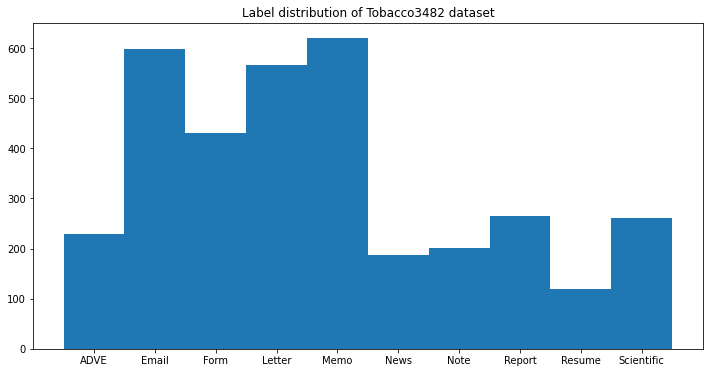

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(labels, bins=range(len(label_to_index)+1))
ax = plt.gca()
ax.set_title('Label distribution of Tobacco3482 dataset')
ax.set_xticks([i + 0.5 for i in range(len(label_to_index))])
_ = ax.set_xticklabels(list(label_to_index.keys()))

In [ ]:
model = build_vgg16_tfidf_model(vectorizer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    input_2[0][0]                    
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 50000)        0           input_3[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

steps_per_epoch=np.ceil(TRAIN_SIZE/BATCH_SIZE)
steps_per_epoch

history = model.fit(ds_train, epochs=100,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=ds_val,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_accuracy', min_delta=0, patience=5, 
                        restore_best_weights=True)])


Epoch 1/100
94/94 [==============================] - 60s 355ms/step - loss: 1.4847 - accuracy: 0.5791 - val_loss: 1.0589 - val_accuracy: 0.6840
Epoch 2/100
94/94 [==============================] - 32s 340ms/step - loss: 0.8898 - accuracy: 0.7566 - val_loss: 1.0009 - val_accuracy: 0.7080
Epoch 3/100
94/94 [==============================] - 32s 346ms/step - loss: 0.6421 - accuracy: 0.8251 - val_loss: 0.8485 - val_accuracy: 0.7240
Epoch 4/100
94/94 [==============================] - 32s 339ms/step - loss: 0.5038 - accuracy: 0.8697 - val_loss: 0.8863 - val_accuracy: 0.7140
Epoch 5/100
94/94 [==============================] - 33s 349ms/step - loss: 0.3639 - accuracy: 0.9069 - val_loss: 0.6430 - val_accuracy: 0.7960
Epoch 6/100
94/94 [==============================] - 32s 342ms/step - loss: 0.2521 - accuracy: 0.9501 - val_loss: 0.8263 - val_accuracy: 0.7560
Epoch 7/100
94/94 [==============================] - 33s 349ms/step - loss: 0.1982 - accuracy: 0.9628 - val_loss: 0.6120 - val_accuracy:

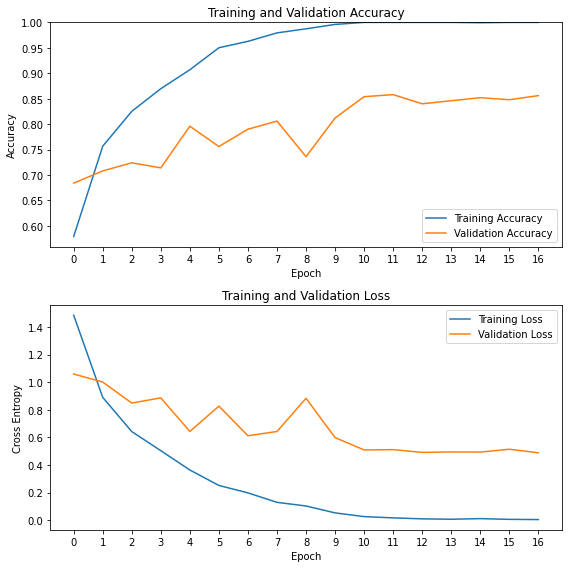

In [ ]:
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.xticks(range(len(train_accuracy)))
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(train_loss)))

plt.tight_layout()
plt.show()

### Evaluation on the test set

In [ ]:
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test accuracy: {test_accuracy}")

93/93 [==============================] - 22s 234ms/step - loss: 0.4178 - accuracy: 0.8650
Test accuracy: 0.8650472164154053


In [ ]:
predictions = model.predict(ds_test)
pred_y = np.argmax(predictions, axis=1)

In [ ]:
print(classification_report(test_y, pred_y, target_names=list(label_to_index.keys()), digits=4))

              precision    recall  f1-score   support

        ADVE     0.9381    0.9381    0.9381        97
       Email     0.9669    0.9564    0.9616       275
        Form     0.7806    0.9273    0.8476       165
      Letter     0.8840    0.8735    0.8787       253
        Memo     0.8840    0.9095    0.8966       243
        News     0.9091    0.8974    0.9032        78
        Note     0.9444    0.7158    0.8144        95
      Report     0.6786    0.6552    0.6667       116
      Resume     0.8462    0.8800    0.8627        50
  Scientific     0.7212    0.6818    0.7009       110

    accuracy                         0.8650      1482
   macro avg     0.8553    0.8435    0.8471      1482
weighted avg     0.8672    0.8650    0.8643      1482



In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = title
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

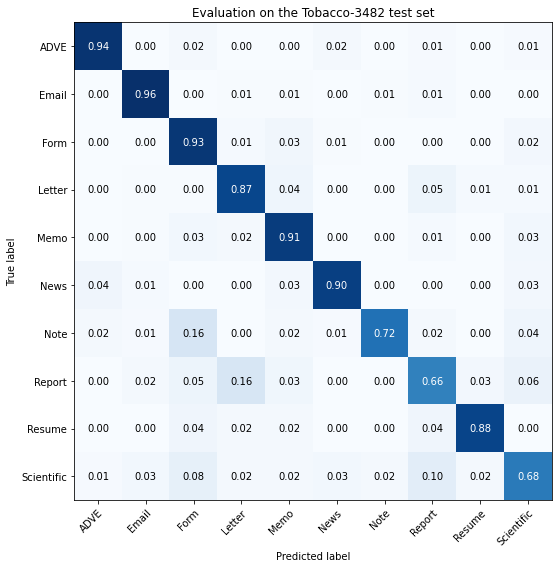

In [ ]:
_ = plot_confusion_matrix(test_y, pred_y, classes=list(label_to_index.keys()), normalize=True, title="Evaluation on the Tobacco-3482 test set")